In [93]:
import glob
import json
import numpy as np
import os

import boto3
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
from pycocotools.coco import COCO
from skimage.io import imread

%matplotlib inline

# set pandas options
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


<h1> Load crop dataset </h1>

In [95]:
analysis_df_path, key = '/root/data/alok/crop_data/data_dumps/analysis_df.h5', 'df'
analysis_df = pd.read_hdf(analysis_df_path, key)

# compute crop size and aspect ratio 
analysis_df['crop_size'] = analysis_df.image_width_px * analysis_df.image_height_px
analysis_df['aspect_ratio'] = analysis_df.image_width_px / analysis_df.image_height_px

<h3> Visualize crop size for crops that were accepted in QA vs. rejected by Cogito </h3>

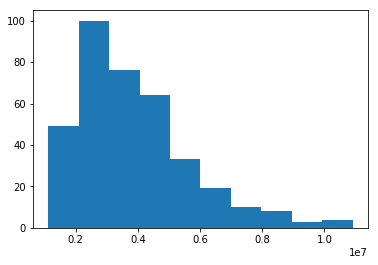

In [96]:
# crop size histogram for crops that are accepted in QA

accepted_mask = (analysis_df.created_by == 'gunnar@aquabyte.ai') & (analysis_df.adult_female_count_adjusted >= 0)
plt.hist(analysis_df[accepted_mask].crop_size)
plt.show()


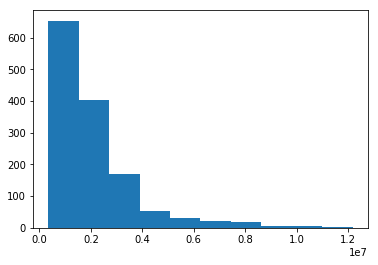

In [97]:
# crop size histogram for crops that are rejected by Cogito

# rejected_mask = (analysis_df.is_skipped == True)
rejected_mask = analysis_df.adult_female_count_adjusted.isnull()
plt.hist(analysis_df[rejected_mask].crop_size)
plt.show()

<h3> Visualize aspect ratio for crops that were accepted in QA versus rejected by Cogito </h3>

In [ ]:
# aspect ratio histogram for crops that are accepted in QA

accepted_mask = (analysis_df.created_by == 'gunnar@aquabyte.ai') & (analysis_df.adult_female_count_adjusted >= 0)
plt.hist(analysis_df[accepted_mask].aspect_ratio)
plt.show()


In [ ]:
# aspect ratio histogram for crops that are rejected by Cogito

# rejected_mask = (analysis_df.is_skipped == True)
rejected_mask = analysis_df.adult_female_count_adjusted.isnull()
plt.hist(analysis_df[rejected_mask].aspect_ratio)
plt.show()

<h1> Create precision / recall curve for training data </h1>

<h3> Define positive outcome as a crop being rejected due to size threshold, and negative outcome as crop being accepted </h3>

In [100]:
true_negative_mask = (analysis_df.created_by == 'gunnar@aquabyte.ai') & (analysis_df.adult_female_count_adjusted >= 0)
true_positive_mask = analysis_df.adult_female_count_adjusted.isnull()

metric = 'crop_size'
thresholds = np.percentile(analysis_df[metric], list(range(100)))
precisions, recalls = [], []
for t in thresholds:
    positive_predictions_mask = analysis_df[metric] < t
    negative_predictions_mask = analysis_df[metric] > t
    false_positive_cnt = analysis_df[positive_predictions_mask & true_negative_mask].shape[0]
    false_negative_cnt = analysis_df[negative_predictions_mask & true_positive_mask].shape[0]
    if analysis_df[positive_predictions_mask].shape[0] > 0:
        precision = analysis_df[positive_predictions_mask & true_positive_mask].shape[0] / \
                    analysis_df[positive_predictions_mask].shape[0]
        recall = analysis_df[positive_predictions_mask & true_positive_mask].shape[0] / \
                    analysis_df[true_positive_mask].shape[0]
        precisions.append(precision)
        recalls.append(recall)
    
    

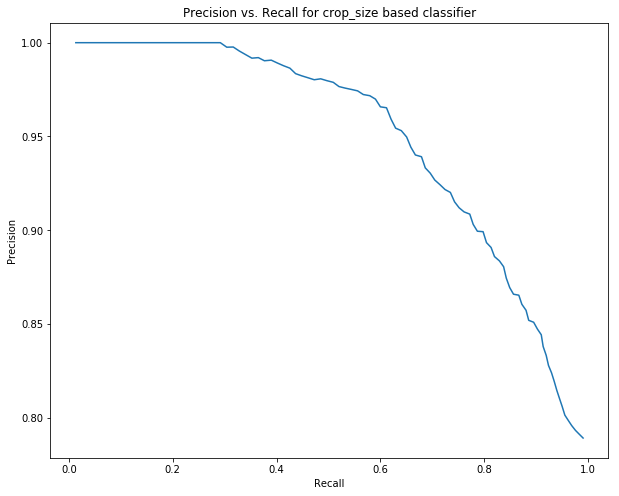

In [101]:
plt.figure(figsize=(10, 8))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall for {} based classifier'.format(metric))
plt.show()

In [103]:
for t, p, r in list(zip(thresholds, precisions, recalls)):
    print(t, p, r)

345828.0 1.0 0.013186813186813187
481781.80000000005 1.0 0.02564102564102564
540784.8 1.0 0.0380952380952381
585213.0 1.0 0.05128205128205128
613757.0 1.0 0.06373626373626373
659954.0 1.0 0.0761904761904762
686045.4 1.0 0.08937728937728938
731193.0 1.0 0.10183150183150183
753132.4 1.0 0.11428571428571428
787360.2999999999 1.0 0.12673992673992673
813260.0 1.0 0.13992673992673993
835381.8 1.0 0.1523809523809524
870357.2 1.0 0.16483516483516483
891487.2 1.0 0.17802197802197803
911384.0000000001 1.0 0.19047619047619047
936919.0 1.0 0.20293040293040293
959325.6 1.0 0.21611721611721613
976697.3 1.0 0.22857142857142856
1007387.3999999999 1.0 0.24102564102564103
1030027.8 1.0 0.25347985347985347
1047625.0 1.0 0.26666666666666666
1069725.3 1.0 0.27912087912087913
1096745.4 1.0 0.2915750915750916
1118009.9000000001 0.9975961538461539 0.304029304029304
1137578.7999999998 0.9976905311778291 0.31648351648351647
1172845.0 0.9955555555555555 0.3282051282051282
1199610.6 0.9935897435897436 0.340659340

In [ ]:
analysis_df[true_positive_mask].shape[0] / analysis_df.shape[0]

<h1> Investigate bad cases </h1>

In [ ]:
threshold = np.percentile(analysis_df.crop_size, list(range(100)))[5]
false_positive_mask = positive_predictions_mask & ~true_positive_mask
tdf = analysis_df[false_positive_mask].sort_values('crop_size', ascending=True).head(10)
tdf


In [ ]:
coco = COCO()
coco.imgs = [
    {
        'height': 3000,
        'width': 4096
    }
]

In [ ]:
i = 1
image_f = tdf.image_path.iloc[i]
im = Image.open(image_f)
ann = {
    'image_id': 0,
    'segmentation': json.loads(tdf.segmentation.iloc[i])['segmentation']
}
m = coco.annToMask(ann)



In [ ]:
im

In [ ]:
Image.fromarray(np.array(im.convert('L')) * m)